In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from scipy import stats

# Model Comparison

To perform a Bayesian analysis we need to define a model (a combination of prior and likelihood) and then apply Bayes theorem. In a magical world we should be able to define the *true* model corresponding to the *true* data generating process. In the real world, we can only hope to define a reasonable enough model to make predictions and/or explain the data. The process of finding this useful model is generally iterative and involves creating more than one candidate model. 

When faced with more than one model for the same data it is *natural* to ask how these models compare to each other. One way to do this is to perform posterior predictive checks as we saw in the previous chapter. Another one is to evaluate the accuracy of the predictions on new data, *i.e.* data not used to fit the model in the first place. It is generally assumed that both datasets come from the *the true generating process*. 

The inconvenience of using new data, is that in general we can not afford the luxury of putting aside a portion of our data and not use it to fit a model. Even in a *big-data regime* we have good reasons to use all the available data, two of them are:

* Reduce the uncertainty of our estimates
* Increase the number of questions we can ask from the data. 

For this reason a number of strategies have been develop in order to evaluate the accuracy of predictions using just the same data used to fit the model, as we will see next.

##  Predictive accuracy

Ideally, any measure of predictive accuracy should take into account the application at hand and it should include benefits and cost of the model's predictions. We discuss such an example in the "chapter XXX Decision-theory". In this chapter we will, instead, discuss very general methods that are applicable to a wide range of models and problems.

A pretty common way of measuring how well a model fits the data is to compute the quadratic mean error between a data-point ($y_i$) and a pointwise prediction $\operatorname{E} (y_i \mid \theta))$:

$$\frac{1}{n} \sum_{i=1}^{n}  (y_i - \operatorname{E} (y_i \mid \theta))^2$$


This is the average of the quadratic differences between observed and predicted data. By taking the square we ensure that (positive and negative) errors do not cancel each other out. Also by taking the square we penalize larger deviations, compared to using for example the absolute value of the differences 


When doing probabilistic forecasting measures of predictive accuracy are generally known as [scoring rules](https://en.wikipedia.org/wiki/Scoring_rule). Given a probability vector $\mathbf{r}$ with a probability for each of the $i$ outcomes. A scoring rule will give a reward of $S({\mathbf {r}}, i)$ if the $i$th event occurs. We say we have a proper scoring rule, if the highest expected reward is obtained by reporting the true probability distribution. A proper scoring rule is said to be local if its value depends only on the probability $r_{i}$.  It can be [shown](https://www.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf) that the logarithmic scoring rule is the only local and proper scoring rule. This is true up to an affine transformation, that is if $S(\mathbf {r} ,i)$ is a strictly proper scoring rule then $a+b S({\mathbf {r}},i)$ with $b>0$ is also a strictly proper scoring rule. Long story short, it is pretty common to use the log-likelihood $\log p(y_i \mid \theta)$ as a measure of the point-wise predictive accuracy.

When the likelihood is Gaussian, then the average log-likelihood will be proportional to the quadratic mean error. For historical reasons people use the *deviance* scale when talking about predictive accuracy, this is simply multiplying the log-likelihood by $-2$:

$$-2\ \sum_{i=1}^{n} \log \ p(y_i \mid \theta)$$

The *deviance* is used in both Bayesians and non-Bayesians context, in the former $\theta$ is a probability distribution and in the latter a point-estimate.


> The lower the deviance, the larger the log-likelihood and thus the greater the agreement between model's predictions and data. We want smaller values of deviance.

In principle the more complex a model (the more parameters to tune) the lower the deviance will be. This is reflecting the intuition that a model with more parameters will be in general more flexible and thus it will fit the data better. Thus relying only on the deviance could lead us to choose models prone to [overfitting](https://en.wikipedia.org/wiki/Overfitting). Overfitting is the tendency of a model to adjust so well to the data used to fit it that it will be very bad at fitting (or generalizing) to new data. For this reason the deviance is used together with a term penalizing the over-complexity of models.

### Akaike Information Criterion  

This is probably the most well known IC, especially for non-Bayesians and is defined as the sum of two terms: The $\log p(y_i \mid \hat{\theta}_{mle})$, measures how well the model fits the data and the penalization term $p_{AIC}$ takes into account that we are using the same data to fit the model and to evaluate the model. 

$$AIC = -2 \sum_{i=1}^{n} \log p(y_i \mid \hat{\theta}_{mle}) + 2 p_{AIC} $$


Here $\hat{\theta}_{mle}$ is the [maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of $\theta$ and $ p_{AIC}$ is just the number of parameters in the model. 

AIC performs well in non-bayesian settings, but is not well equipped to deal with the generality of Bayesian models. It does not use the full *a posteriori* distribution, discarding potentially useful information. On average AIC will behave worst as we increase the information in the priors, or in general the structure in our model. Thus it is not compatible with informative and weakly informative priors, neither with hierarchical models. AIC assumes that the posterior can be well represented (at least asymptotically) by a Gaussian distribution, but this is not true for a number of models, including hierarchical models, mixture models, neural networks, etc. Fortunately, we have better alternatives.

## Widely available information criterion 

WAIC, generally pronounced as W-A-I-C, even when something like *wæɪk* is less of a mouthful ;-) can be regarded as a fully Bayesian extension of AIC. It also has two terms, although computed in a different way. The most important difference is that the terms are computed using the full posterior distribution, including the *effective* number of parameters.


It also has two terms, although computed in a different way, being the most important difference that the terms are computed using the full posterior distribution, including the *effective* number of parameters. For details on the computation of WAIC please read the WAIC in depth section.


## Pareto smoothed importance sampling leave-one-out cross validation

[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) (CV) is another method of estimating out-of-sample prediction accuracy. This method requires re-fitting a model many times, each time excluding a portion of the data, the excluded portion is then used to measure the accuracy of them model. This process is repeated many times and the estimated accuracy of the model will be the average of each run. Then the entire dataset is used to fit the model one more time and this is the model used for further analysis and/or predictions. Leave-one-out cross-validation (LOO-CV) is a particular type of cross-validation when the data excluded is a single data-point. 

As CV can be quite time consuming (especially for Bayesian models) it is interesting to note that in theory it is possible to approximate LOO-CV. A practical and computational efficient way to do it requires using a combination of strategies that includes what is called [Pareto smoothed importance sampling](https://arxiv.org/abs/1507.02646). The resulting method is known as PSIS-LOO-CV which, while very useful, has a very complicated name, thus we just call it LOO. 


While LOO and WAIC approximate two different quantities, asymptotically they converge to the same numerical value, and also in practice they generally agree. The main advantage of LOO is that it is more informative as it provides [useful diagnostics](https://arxiv.org/abs/1507.04544) and other goodies such as effective sample size and Monte Carlo standard error estimates.

Using ArviZ, both LOO and WAIC can be computed just by calling a function. Let's try on an arbitrary pre-loaded model:

In [2]:
# change this to some good example
model0 = az.load_arviz_data('regression1d')
model1 = az.load_arviz_data('regression1d')

In [3]:
az.waic(model0)

Computed from 2000 by 100 log-likelihood matrix

          Estimate       SE
elpd_waic  -145.85     5.71
p_waic        2.73        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [4]:
az.loo(model0)

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -145.85     5.71
p_loo        2.73        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

As you can see both WAIC and LOO return similar values. ArviZ comes equipped with the `compare(.)` function. That is more convenient than using `loo(.)` or `waic(.)` 

In [5]:
az.loo(model0)

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -145.85     5.71
p_loo        2.73        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

## The compare function

This function takes a dictionary of names (keys) and models (values) as input and returns a DataFrame ordered (row-wise) from best to worst model.



In [6]:
cmp = az.compare({"m0":model0, "m1":model1,})
cmp

/home/osvaldo/proyectos/00_BM/arviz/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m0,0,-145.855,2.7325,0,0.5,5.66942,0,False,log
m1,1,-145.855,2.7325,0,0.5,5.66942,0,False,log


We have many columns, so let's check out their meaning one by one:

0) The index are the names of the models taken from the keys of the dictionary passed to `compare(.)`.

1) **rank**, the ranking on the models starting from 0 (best model) to the number of models.

2) **waic**, the values of WAIC/LOO. The DataFrame is always sorted from best WAIC/LOO to worst. 

3) **p_waic**, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).

4) **d_waic**, the relative difference between the value of WAIC/LOO for the top-ranked model and the value of WAIC/LOO for each model. For this reason we will always get a value of 0 for the first model.

5) **weight**, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model (among the compared models) given the data. See model averaging section for more details.

6) **se**, the standard error for the WAIC/LOO computations. The standard error can be useful to assess the uncertainty of the WAIC/LOO estimates. By default these errors are computed using bootstrapping.

7) **dse**, the standard errors of the difference between two values of WAIC/LOO. The same way that we can compute the standard error for each value of WAIC/LOO, we can compute the standard error of the differences between two values of WAIC/LOO. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about WAIC/LOO is correlated between models. This quantity is always 0 for the top-ranked model.

8) **warning**, when computing WAIC/LOO, the possible values can be `True` or `False`. If `True` the computation of WAIC/LOO may not be reliable. This warning for WAIC is based on an empirical determined cutoff value and need to be interpreted with caution. The warning for LOO has better empirical and theoretical support.

9) **waic_scale**, the scale of the reported values. The default is the deviance scale as previously mentioned this is obtained by multiplying the log-score by -2. Other options are log -- this is the log-score multiplied by 1 (this reverts the order: a higher WAIC/LOO will be better) -- and negative-log -- this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better).

## The plot_compare function

ArviZ also provides another convenience function that takes the output of `compare(.)` and produces a summary plot in the style of the one used in the book Statistical Rethinking by Richard McElreath.

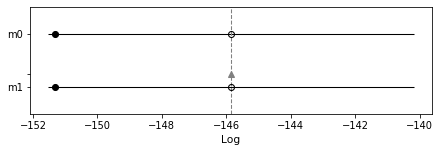

In [7]:
az.plot_compare(cmp);

The empty circle represents the values of WAIC/LOO and the black error bars associated with them are the values of the standard deviation of WAIC/LOO.

The value of the best WAIC/LOO is also indicated with a vertical dashed grey line to ease comparison with other WAIC/LOO values.

The filled black dots are the in-sample deviance of each model, i.e. the log-score without the penalty term.

For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey errorbar indicating the standard error of the differences between the top-ranked WAIC/LOO and WAIC/LOO for each model.

## Point-wise model comparison

Comparing models is a good way to get a better understanding about them... 